## **Installing and Importing**

In [1]:
import os
# Find the latest version of spark 3.x  from http://www.apache.org/dist/spark/ and enter as the spark version
spark_version = 'spark-3.4.1'
os.environ['SPARK_VERSION']=spark_version

# Install Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/$SPARK_VERSION/$SPARK_VERSION-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Set Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Start a SparkSession
import findspark
findspark.init()

Get:1 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Hit:4 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:5 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:6 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease [18.1 kB]
Get:7 http://security.ubuntu.com/ubuntu jammy-security/main amd64 Packages [1,082 kB]
Get:8 http://security.ubuntu.com/ubuntu jammy-security/universe amd64 Packages [1,005 kB]
Get:9 http://archive.ubuntu.com/ubuntu jammy-backports InRelease [109 kB]
Hit:10 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:11 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [1,347 kB]
Hit:12 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Get:13 http://archive.ubuntu.com

In [2]:
# Import packages
from pyspark.sql import SparkSession, Row
from pyspark.sql.types import StructType,StructField,StringType, DateType,IntegerType

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

In [3]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

## Reading CSV and Exploring Data

In [4]:
#  Import and read the Heart_Disease_Prediction.csv
from pyspark import SparkFiles
url = "https://raw.githubusercontent.com/AleidvdZ/Project4HeartDisease/main/Heart_Disease_Prediction.csv"
spark.sparkContext.addFile(url)
hd_df = spark.read.csv(SparkFiles.get("Heart_Disease_Prediction.csv"), sep=",", header=True)

# Show DataFrame
hd_df.show()

+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|index|Age|Sex|Chest pain type| BP|Cholesterol|FBS over 120|EKG results|Max HR|Exercise angina|ST depression|Slope of ST|Number of vessels fluro|Thallium|Heart Disease|
+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|    0| 70|  1|              4|130|        322|           0|          2|   109|              0|          2.4|          2|                      3|       3|     Presence|
|    1| 67|  0|              3|115|        564|           0|          2|   160|              0|          1.6|          2|                      0|       7|      Absence|
|    2| 57|  1|              2|124|        261|           0|          0|   141|              0|          0.3|          1|                      0|       7| 

In [5]:
#Replace whitespaces in column headers with underscore
from pyspark.sql import functions as F

hd_df = hd_df.select([F.col(col).alias(col.replace(' ', '_')) for col in hd_df.columns])

hd_df.show()

+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|index|Age|Sex|Chest_pain_type| BP|Cholesterol|FBS_over_120|EKG_results|Max_HR|Exercise_angina|ST_depression|Slope_of_ST|Number_of_vessels_fluro|Thallium|Heart_Disease|
+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|    0| 70|  1|              4|130|        322|           0|          2|   109|              0|          2.4|          2|                      3|       3|     Presence|
|    1| 67|  0|              3|115|        564|           0|          2|   160|              0|          1.6|          2|                      0|       7|      Absence|
|    2| 57|  1|              2|124|        261|           0|          0|   141|              0|          0.3|          1|                      0|       7| 

In [6]:
from pyspark.sql.functions import when, col
hd_df = hd_df.withColumn("Heart_Disease", when(col("Heart_Disease") == "Presence", 1).when(col("Heart_Disease") == "Absence", 0).otherwise(col("Heart_Disease")))

# Display the DataFrame
hd_df.show()

+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|index|Age|Sex|Chest_pain_type| BP|Cholesterol|FBS_over_120|EKG_results|Max_HR|Exercise_angina|ST_depression|Slope_of_ST|Number_of_vessels_fluro|Thallium|Heart_Disease|
+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|    0| 70|  1|              4|130|        322|           0|          2|   109|              0|          2.4|          2|                      3|       3|            1|
|    1| 67|  0|              3|115|        564|           0|          2|   160|              0|          1.6|          2|                      0|       7|            0|
|    2| 57|  1|              2|124|        261|           0|          0|   141|              0|          0.3|          1|                      0|       7| 

In [7]:
for col_name in hd_df.columns:
    hd_df = hd_df.withColumn(col_name, col(col_name).cast('integer'))

# Display the DataFrame
hd_df.show()

+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|index|Age|Sex|Chest_pain_type| BP|Cholesterol|FBS_over_120|EKG_results|Max_HR|Exercise_angina|ST_depression|Slope_of_ST|Number_of_vessels_fluro|Thallium|Heart_Disease|
+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|    0| 70|  1|              4|130|        322|           0|          2|   109|              0|            2|          2|                      3|       3|            1|
|    1| 67|  0|              3|115|        564|           0|          2|   160|              0|            1|          2|                      0|       7|            0|
|    2| 57|  1|              2|124|        261|           0|          0|   141|              0|            0|          1|                      0|       7| 

In [8]:
# Show schema
hd_df.printSchema()

root
 |-- index: integer (nullable = true)
 |-- Age: integer (nullable = true)
 |-- Sex: integer (nullable = true)
 |-- Chest_pain_type: integer (nullable = true)
 |-- BP: integer (nullable = true)
 |-- Cholesterol: integer (nullable = true)
 |-- FBS_over_120: integer (nullable = true)
 |-- EKG_results: integer (nullable = true)
 |-- Max_HR: integer (nullable = true)
 |-- Exercise_angina: integer (nullable = true)
 |-- ST_depression: integer (nullable = true)
 |-- Slope_of_ST: integer (nullable = true)
 |-- Number_of_vessels_fluro: integer (nullable = true)
 |-- Thallium: integer (nullable = true)
 |-- Heart_Disease: integer (nullable = true)



In [9]:
# Create a temporary view of the DataFrame.
hd_df.createOrReplaceTempView('data')

# Look at data using SparkSQL
spark.sql("select * from data limit 10").show()

+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|index|Age|Sex|Chest_pain_type| BP|Cholesterol|FBS_over_120|EKG_results|Max_HR|Exercise_angina|ST_depression|Slope_of_ST|Number_of_vessels_fluro|Thallium|Heart_Disease|
+-----+---+---+---------------+---+-----------+------------+-----------+------+---------------+-------------+-----------+-----------------------+--------+-------------+
|    0| 70|  1|              4|130|        322|           0|          2|   109|              0|            2|          2|                      3|       3|            1|
|    1| 67|  0|              3|115|        564|           0|          2|   160|              0|            1|          2|                      0|       7|            0|
|    2| 57|  1|              2|124|        261|           0|          0|   141|              0|            0|          1|                      0|       7| 

To analyze:

*  Total number of indiviuals
*  Number/percent of individuals of each sex
*  Mean/Median/Mode of ages by sex
*  % of male/female with heart disease

In [10]:
# Total number of indiviuals
spark.sql("""
  SELECT COUNT(index) AS Num_of_Individuals
  FROM data
    """).show()

+------------------+
|Num_of_Individuals|
+------------------+
|               270|
+------------------+



In [11]:
# Mean/Median/Mode of ages (by sex)
spark.sql("""
  SELECT
    MIN(Age) AS min_age,
    MAX(Age) AS max_age,
    ROUND(AVG(Age),1) AS mean_age,
    PERCENTILE_CONT(0.5) WITHIN GROUP (ORDER BY Age) AS median_age,
    ROUND(STDDEV(Age),1) AS std_deviation,
    COUNT(Age) AS Num_of_Individuals
FROM data;
    """).show()

+-------+-------+--------+----------+-------------+------------------+
|min_age|max_age|mean_age|median_age|std_deviation|Num_of_Individuals|
+-------+-------+--------+----------+-------------+------------------+
|     29|     77|    54.4|      55.0|          9.1|               270|
+-------+-------+--------+----------+-------------+------------------+



In [12]:
# Percent of individuals of each sex (0 = female, 1 = male)
spark.sql("""
  SELECT Sex,
  COUNT(*) AS Frequency
  FROM data
  GROUP BY Sex
  ORDER BY Sex
  """).show()

+---+---------+
|Sex|Frequency|
+---+---------+
|  0|       87|
|  1|      183|
+---+---------+



In [14]:
# Percent of individuals of each sex (Sex: 0 = female, 1 = male) with and without heart disease (Heart_Disease: 0 = without, 1 = with)
spark.sql("""
  SELECT Sex, Heart_Disease,
  COUNT(*) AS Frequency
  FROM data
  GROUP BY Sex, Heart_Disease
  ORDER BY Sex
""").show()

+---+-------------+---------+
|Sex|Heart_Disease|Frequency|
+---+-------------+---------+
|  0|            0|       67|
|  0|            1|       20|
|  1|            0|       83|
|  1|            1|      100|
+---+-------------+---------+



## **Preprocessing Data**


Scaling: Age, BP, Cholesterol, MaxHR, StDep  
Dummy (more than 2 categories): Chest Pain, EKG Result, Slope of ST, Thalium  

## **Machine Learning Model - Neural Network**

In [15]:
#convert to pandas
pandas_df = hd_df.toPandas()
pandas_df.head()

,index,Age,Sex,Chest_pain_type,BP,Cholesterol,FBS_over_120,EKG_results,Max_HR,Exercise_angina,ST_depression,Slope_of_ST,Number_of_vessels_fluro,Thallium,Heart_Disease
0,0,70,1,4,130,322,0,2,109,0,2,2,3,3,1
1,1,67,0,3,115,564,0,2,160,0,1,2,0,7,0
2,2,57,1,2,124,261,0,0,141,0,0,1,0,7,1
3,3,64,1,4,128,263,0,0,105,1,0,2,1,7,0
4,4,74,0,2,120,269,0,2,121,1,0,1,1,3,0


In [16]:
# Create new columns for get_dummies
dummy_cols = ["Chest_pain_type", "EKG_results", "Slope_of_ST", "Thallium"]
pandas_dummies_df = pd.get_dummies(pandas_df, columns=dummy_cols)
pandas_dummies_df.head()

,index,Age,Sex,BP,Cholesterol,FBS_over_120,Max_HR,Exercise_angina,ST_depression,Number_of_vessels_fluro,...,Chest_pain_type_4,EKG_results_0,EKG_results_1,EKG_results_2,Slope_of_ST_1,Slope_of_ST_2,Slope_of_ST_3,Thallium_3,Thallium_6,Thallium_7
0,0,70,1,130,322,0,109,0,2,3,...,1,0,0,1,0,1,0,1,0,0
1,1,67,0,115,564,0,160,0,1,0,...,0,0,0,1,0,1,0,0,0,1
2,2,57,1,124,261,0,141,0,0,0,...,0,1,0,0,1,0,0,0,0,1
3,3,64,1,128,263,0,105,1,0,1,...,1,1,0,0,0,1,0,0,0,1
4,4,74,0,120,269,0,121,1,0,1,...,0,0,0,1,1,0,0,1,0,0


# **Neural Network Model Metrics**

In [17]:
#%%python
# Remove Heart Disease target from features data (NOTE: NEED TO UPDATE COLUMNS)
y = pandas_dummies_df['Heart_Disease'].values
X = pandas_dummies_df.drop(columns=["Heart_Disease"]).values

# Split training/test datasets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=1, stratify=y)

In [18]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [19]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train[0])
hidden_nodes_layer1 =  8
hidden_nodes_layer2 = 3

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer1, input_dim=number_input_features, activation="relu"))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=hidden_nodes_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 192       
                                                                 
 dense_1 (Dense)             (None, 3)                 27        
                                                                 
 dense_2 (Dense)             (None, 1)                 4         
                                                                 
Total params: 223 (892.00 Byte)
Trainable params: 223 (892.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [20]:
# Compile the model
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [21]:
# Train the model
fit_model = nn.fit(X_train_scaled,y_train,epochs=100)

Epoch 1/100
7/7 [==============================] - 2s 17ms/step - loss: 0.7827 - accuracy: 0.4653
Epoch 2/100
7/7 [==============================] - 0s 10ms/step - loss: 0.7568 - accuracy: 0.5050
Epoch 3/100
7/7 [==============================] - 0s 6ms/step - loss: 0.7360 - accuracy: 0.5248
Epoch 4/100
7/7 [==============================] - 0s 5ms/step - loss: 0.7183 - accuracy: 0.5396
Epoch 5/100
7/7 [==============================] - 0s 5ms/step - loss: 0.7026 - accuracy: 0.5743
Epoch 6/100
7/7 [==============================] - 0s 5ms/step - loss: 0.6895 - accuracy: 0.5842
Epoch 7/100
7/7 [==============================] - 0s 6ms/step - loss: 0.6778 - accuracy: 0.6089
Epoch 8/100
7/7 [==============================] - 0s 8ms/step - loss: 0.6676 - accuracy: 0.6139
Epoch 9/100
7/7 [==============================] - 0s 22ms/step - loss: 0.6584 - accuracy: 0.6337
Epoch 10/100
7/7 [==============================] - 0s 17ms/step - loss: 0.6497 - accuracy: 0.6535
Epoch 11/100
7/7 [=======

In [22]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

3/3 - 0s - loss: 0.4376 - accuracy: 0.8824 - 261ms/epoch - 87ms/step
Loss: 0.4375714361667633, Accuracy: 0.8823529481887817


In [23]:
## Discard
# Making predictions using the testing data
predictions = fit_model.predict(X_test_scaled)

AttributeError: ignored

In [ ]:
##Discard
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

NameError: ignored

In [ ]:
## discard
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

##**Binary Model Metrics**

In [24]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score


In [25]:
# y_test contains the true labels for the testing set
y_true = y_test

In [26]:
y_pred = fit_model.predict(X_test)

AttributeError: ignored

In [ ]:
y_pred_binary = (y_pred > 0.5).astype(int)

##**Ploting ROC and AUC**

In [ ]:

from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)

# Calculate AUC
roc_auc = auc(fpr, tpr)

print("Area under the ROC curve (AUC):", roc_auc)

NameError: ignored

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()


NameError: ignored

<Figure size 800x600 with 0 Axes>

## **Logistic Regression**

In [ ]:
from sklearn.linear_model import LogisticRegression
classifier = LogisticRegression( random_state=1)
classifier

LogisticRegression(random_state=42)

In [ ]:
# Train the data
classifier.fit(X_train, y_train)

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(random_state=42)

In [ ]:
print(f"Training Data Score: {classifier.score(X_train, y_train)}")
print(f"Testing Data Score: {classifier.score(X_test, y_test)}")

Training Data Score: 0.8762376237623762
Testing Data Score: 0.9264705882352942


In [ ]:
predictions = classifier.predict(X_test)
results = pd.DataFrame({"Prediction": predictions, "Actual": y_test}).reset_index(drop=True)
results.head(10)

,Prediction,Actual
0,1,1
1,0,1
2,0,0
3,0,0
4,0,0
5,0,0
6,1,1
7,1,1
8,0,0
9,1,1


In [ ]:
from sklearn.metrics import accuracy_score
# Display the accuracy score for the test dataset.
accuracy_score(y_test, predictions)

0.9264705882352942

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

ROC of Logistic Regression

In [ ]:

from sklearn.metrics import roc_curve, auc

# Calculate ROC curve
fpr, tpr, _ = roc_curve(y_test, predictions)

# Calculate AUC
roc_auc = auc(fpr, tpr)

print("Area under the ROC curve (AUC):", roc_auc)

In [ ]:
import matplotlib.pyplot as plt

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

### **Random Forest**

In [ ]:
#Decision Tree modeling
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(n_estimators=100, random_state=1)

In [ ]:
# Fitting the model
rf_model = rf_model.fit(X_train_scaled, y_train)

In [ ]:
# Making predictions using the testing data
predictions = rf_model.predict(X_test_scaled)

In [ ]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

cm = confusion_matrix(y_test, predictions)
cm_df = pd.DataFrame(cm, index=["Actual 0", "Actual 1"], columns=["Predicted 0", "Predicted 1"])

# Calculating the accuracy score
acc_score = accuracy_score(y_test, predictions)

In [ ]:
# Displaying results
print("Confusion Matrix")
display(cm_df)
print(f"Accuracy Score : {acc_score}")
print("Classification Report")
print(classification_report(y_test, predictions))

Confusion Matrix


,Predicted 0,Predicted 1
Actual 0,34,4
Actual 1,3,27


Accuracy Score : 0.8970588235294118
Classification Report
              precision    recall  f1-score   support

           0       0.92      0.89      0.91        38
           1       0.87      0.90      0.89        30

    accuracy                           0.90        68
   macro avg       0.89      0.90      0.90        68
weighted avg       0.90      0.90      0.90        68



### **Feature Importance**

In [ ]:
import pandas as pd
from pathlib import Path
%matplotlib inline

In [ ]:
X = pandas_df.copy()
X.drop(columns=["Heart_Disease", "index"], axis=1, inplace=True)
X = pd.DataFrame(X)

In [ ]:
# Random Forests in sklearn will automatically calculate feature importance
importance = rf_model.feature_importances_

# We can sort the features by their importance
sorted(zip(rf_model.feature_importances_, X.columns), reverse=True)

[(0.11852418451773611, 'EKG_results'),
 (0.09304098996181889, 'Cholesterol'),
 (0.08037219146976764, 'ST_depression'),
 (0.06967342454992186, 'Sex'),
 (0.06795028348447245, 'BP'),
 (0.06775563132770517, 'Age'),
 (0.047794655735333175, 'Exercise_angina'),
 (0.03309049245565491, 'Chest_pain_type'),
 (0.02879489652962605, 'Max_HR'),
 (0.022298888200036424, 'Thallium'),
 (0.012584400946873603, 'Slope_of_ST'),
 (0.010649761086703513, 'FBS_over_120'),
 (0.010186264895212075, 'Number_of_vessels_fluro')]

<Axes: title={'center': 'Features Importances'}, ylabel='1'>

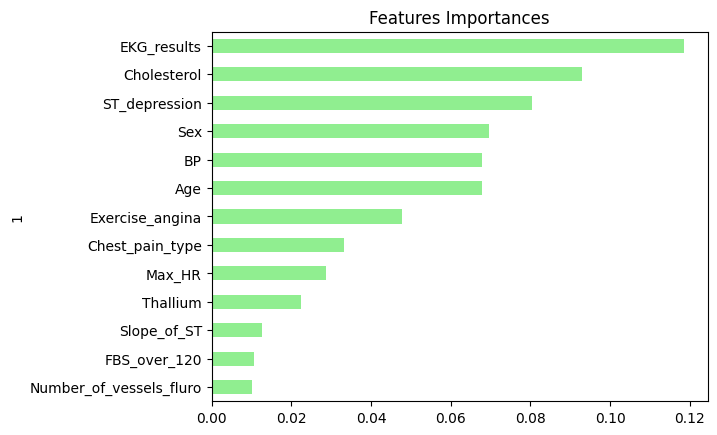

In [ ]:
# Visualize the features by importance
importances_df = pd.DataFrame(sorted(zip(rf_model.feature_importances_, X.columns), reverse=True))
importances_df.set_index(importances_df[1], inplace=True)
importances_df.drop(columns=1, inplace=True)
importances_df.rename(columns={0: 'Feature Importances'}, inplace=True)
importances_sorted = importances_df.sort_values(by='Feature Importances')
importances_sorted.plot(kind='barh', color='lightgreen', title= 'Features Importances', legend=False)

In [ ]:
#Trim less relevant columns from df

cols_to_drop = ['index', 'Exercise_angine', 'Chest_pain_type', 'Max_HR', 'Thallium', 'Slope_of_ST', 'FBS_over_120', 'Number_of_vessels_fluro']
trimmed_df = hd_df.drop(*cols_to_drop)

trimmed_df.show()

+---+---+---+-----------+-----------+---------------+-------------+-------------+
|Age|Sex| BP|Cholesterol|EKG_results|Exercise_angina|ST_depression|Heart_Disease|
+---+---+---+-----------+-----------+---------------+-------------+-------------+
| 70|  1|130|        322|          2|              0|            2|            1|
| 67|  0|115|        564|          2|              0|            1|            0|
| 57|  1|124|        261|          0|              0|            0|            1|
| 64|  1|128|        263|          0|              1|            0|            0|
| 74|  0|120|        269|          2|              1|            0|            0|
| 65|  1|120|        177|          0|              0|            0|            0|
| 56|  1|130|        256|          2|              1|            0|            1|
| 59|  1|110|        239|          2|              1|            1|            1|
| 60|  1|140|        293|          2|              0|            1|            1|
| 63|  0|150|   

## **Support Vector Machine**

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [ ]:
# Train the SVM model
svm_model = SVC(kernel='linear', random_state=1)
svm_model.fit(X_train, y_train)

SVC(kernel='linear', random_state=1)

In [ ]:
# Predictions
y_pred = svm_model.predict(X_test)

In [ ]:
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Classification Report:")
print(classification_report(y_test, y_pred))

Accuracy: 0.8970588235294118
Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.92      0.91        38
           1       0.90      0.87      0.88        30

    accuracy                           0.90        68
   macro avg       0.90      0.89      0.90        68
weighted avg       0.90      0.90      0.90        68

